In [60]:
# Part 0: general imports
import csv
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np

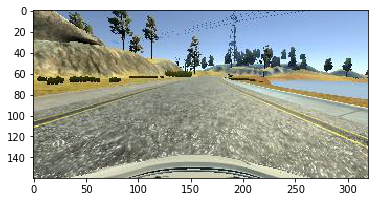

In [61]:
# Part 1: show a frame 
img = cv2.imread(glob.glob('data/IMG/center_*')[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [71]:
# Part 2: load data for X and y
with open('data/driving_log.csv') as f_csv:
    telemetry = [l for l in csv.reader(f_csv)]

center_im_idx =      0
steering_angle_idx = 3

def read_image_rgb(path):
    tmp_im = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

X = np.array([read_image_rgb(line[center_im_idx]) for line in telemetry], dtype=np.int64)
# X = X / 255 - .5 # mean variance normalization
y = np.array([line[steering_angle_idx] for line in telemetry], dtype=np.float32)

[ 0.          0.          0.          0.          0.          0.
 -0.03674225 -0.3351739  -0.61034417 -0.63410479 -0.5889039  -0.53515631
 -0.4683682  -0.46551931 -0.43896851 -0.37226859 -0.29837289 -0.27907661
 -0.27907661 -0.27622771 -0.16691139 -0.08432212 -0.08147322 -0.05363017
  0.06205945  0.1467634   0.1136337   0.02425987 -0.1214462  -0.30404139
 -0.36818609 -0.43233079 -0.43233079 -0.3589932  -0.25469929 -0.03127937
  0.07809563  0.07809563  0.08599624  0.19892509  0.19892509  0.1960468
  0.1960468   0.1960468   0.1960468   0.1960468   0.01259986 -0.07098801
 -0.08467457 -0.09043115 -0.181949   -0.26700541 -0.29437849 -0.283629
 -0.2075305  -0.2132871  -0.21616539 -0.21616539 -0.15437029  0.01039709
  0.06194196  0.07554042  0.06978384  0.1013863   0.1013569   0.09847862
 -0.09648144 -0.1123414  -0.1152197  -0.1152197  -0.1728736  -0.17002469
 -0.17002469 -0.17002469 -0.1830063  -0.1310209  -0.06502584 -0.03498003
 -0.03498003 -0.01283482 -0.03732965 -0.07551105 -0.0870242  -

In [70]:
# Part 3: train the model
from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda
from keras.layers.convolutional import Cropping2D

model = Sequential()
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
model.add(Lambda(lambda x: x / 255.0 - .5))
model.add(Flatten())
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(X, y, nb_epoch=10, batch_size=32, verbose=True, validation_split=0.3)
model.save('model/model.h5')

Train on 3397 samples, validate on 1457 samples
Epoch 1/10
3397/3397 [==============================] - 5s - loss: 3.6926 - acc: 0.0659 - val_loss: 0.0382 - val_acc: 0.0927